<a href="https://colab.research.google.com/github/jdz014/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS12_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [1]:
!wget 'https://raw.githubusercontent.com/washingtonpost/data-school-shootings/master/school-shootings-data.csv'

--2020-02-27 05:51:35--  https://raw.githubusercontent.com/washingtonpost/data-school-shootings/master/school-shootings-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70530 (69K) [text/plain]
Saving to: ‘school-shootings-data.csv’

school-shootings-da 100%[===================>]  68.88K  --.-KB/s    in 0.03s   

2020-02-27 05:51:40 (2.45 MB/s) - ‘school-shootings-data.csv’ saved [70530/70530]



In [26]:
import pandas as pd

df = pd.read_csv('school-shootings-data.csv')
print(df.shape)
df.head()

(238, 50)


,uid,nces_school_id,school_name,nces_district_id,district_name,date,school_year,year,time,day_of_week,city,state,school_type,enrollment,killed,injured,casualties,shooting_type,age_shooter1,gender_shooter1,race_ethnicity_shooter1,shooter_relationship1,shooter_deceased1,deceased_notes1,age_shooter2,gender_shooter2,race_ethnicity_shooter2,shooter_relationship2,shooter_deceased2,deceased_notes2,white,black,hispanic,asian,american_indian_alaska_native,hawaiian_native_pacific_islander,two_or_more,resource_officer,weapon,weapon_source,lat,long,staffing,low_grade,high_grade,lunch,county,state_fips,county_fips,ulocale
0,1,080480000707,Columbine High School,804800.0,Jefferson County R-1,4/20/1999,1998-1999,1999,11:19 AM,Tuesday,Littleton,Colorado,public,1965,13,21,34,indiscriminate,18.0,m,w,student,1.0,suicide,17.0,m,w,student,1.0,suicide,1783,16.0,112.0,42.0,12.0,NaN,NaN,1,12-gauge Savage-Springfield 67H pump-action sh...,purchased from friends,39.603910,-105.075000,89.6,9,12,41.0,Jefferson County,8,8059,21.0
1,2,220054000422,Scotlandville Middle School,2200540.0,East Baton Rouge Parish School Board,4/22/1999,1998-1999,1999,12:30 PM,Thursday,Baton Rouge,Louisiana,public,588,0,1,1,targeted,14.0,m,NaN,former student (expelled),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,583.0,0.0,0.0,0.0,NaN,NaN,0,.22-caliber handgun,NaN,30.529958,-91.169966,39.0,6,8,495.0,East Baton Rouge Parish,22,22033,12.0
2,3,130441001591,Heritage High School,1304410.0,Rockdale County,5/20/1999,1998-1999,1999,8:03 AM,Thursday,Conyers,Georgia,public,"1,369",0,6,6,indiscriminate,15.0,m,w,student,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1189,136.0,28.0,15.0,1.0,NaN,NaN,1,".22-caliber rifle, .357-caliber Magnum handgun",NaN,33.626922,-84.047960,84.0,9,12,125.0,Rockdale County,13,13247,21.0
3,4,421899003847,John Bartram High School,4218990.0,Philadelphia City SD,10/4/1999,1999-2000,1999,10:00 AM,Monday,Philadelphia,Pennsylvania,public,3147,0,1,1,targeted,17.0,m,NaN,student,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209,2736.0,27.0,170.0,5.0,NaN,NaN,1,RG .25-caliber handgun,purchased from friend,39.921509,-75.234108,41.0,9,12,2007.0,Philadelphia County,42,42101,11.0
4,5,250279000225,Dorchester High School,2502790.0,Boston,11/3/1999,1999-2000,1999,7:40 AM,Wednesday,Boston,Massachusetts,public,"1,116",0,1,1,targeted,NaN,m,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,755.0,287.0,29.0,5.0,NaN,NaN,0,NaN,NaN,42.285268,-71.075901,NaN,9,12,543.0,Suffolk County,25,25025,11.0


In [0]:
# Replace shooting type with 'other' for rows not 'targeted' or 'indiscriminate'
  df['shooting_type'] = df['shooting_type'].replace(['accidental', 'unclear',
                                                    'targeted and indiscriminate',
                                                    'public suicide',
                                                    'hostage suicide',
                                                    'accidental or targeted',
                                                    'public suicide (attempted)'],
                                                    'other')

# Fill missing value with 'other'
  df['shooting_type'] = df['shooting_type'].fillna('other')

In [28]:
# Majority class baseline 59%
df['shooting_type'].value_counts(normalize=True)

targeted          0.588235
other             0.222689
indiscriminate    0.189076
Name: shooting_type, dtype: float64

In [29]:
from sklearn.model_selection import train_test_split

# Create train, test
train, test = train_test_split(df, train_size=0.80, random_state=21, stratify=df['shooting_type'])

train.shape, test.shape

((190, 50), (48, 50))

In [30]:
def wrangle(df):

  # Avoid SettingWithCopyWarning
  df = df.copy()

  # Remove commas from numbers
  df['white'] = df['white'].str.replace(",", "")

  # Change from object to int
  df['white'] = pd.to_numeric(df['white'])
  
  # Remove commas from numbers
  df['enrollment'] = df['enrollment'].str.replace(",", "")

  # Change from object to int
  df['enrollment'] = pd.to_numeric(df['enrollment'])

  # Fill missing values for these specific columns
  df.fillna({'white': 0, 'black': 0, 'hispanic': 0, 'asian': 0,
           'american_indian_alaska_native': 0,
           'hawaiian_native_pacific_islander': 0, 'two_or_more': 0,
           'district_name': 'Unknown', 'time': '12:00 PM', 'lat': 33.612910,
           'long': -86.682000, 'staffing': 60.42, 'low_grade': '9',
           'high_grade': '12'}, inplace=True)
  
  # Drop columns with 200+ missing values
  df = df.drop(columns=['deceased_notes1', 'age_shooter2', 'gender_shooter2', 
                        'race_ethnicity_shooter2', 'shooter_relationship2', 
                        'shooter_deceased2', 'deceased_notes2'])

  # Drop unusable variance 
  df = df.drop(columns=['uid', 'nces_school_id', 'nces_district_id', 'weapon', 
                        'weapon_source', 'state_fips', 'county_fips', 'ulocale',
                        'lunch', 'age_shooter1', 'gender_shooter1',
                        'race_ethnicity_shooter1', 'shooter_relationship1',
                        'shooter_deceased1'])
  
  # Change date to datettime
  df['date'] = pd.to_datetime(df['date'])

  return df

train = wrangle(train)
test = wrangle(test)

train.shape, test.shape

((190, 29), (48, 29))

In [31]:
!pip install category_encoders==2.*
!pip install eli5

In [0]:
target = 'shooting_type'
features = train.columns.drop([target, 'date'])
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [35]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),  
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on test
pipeline.fit(X_train, y_train)
print('Test Accuracy', pipeline.score(X_test, y_test))

Test Accuracy 0.5625


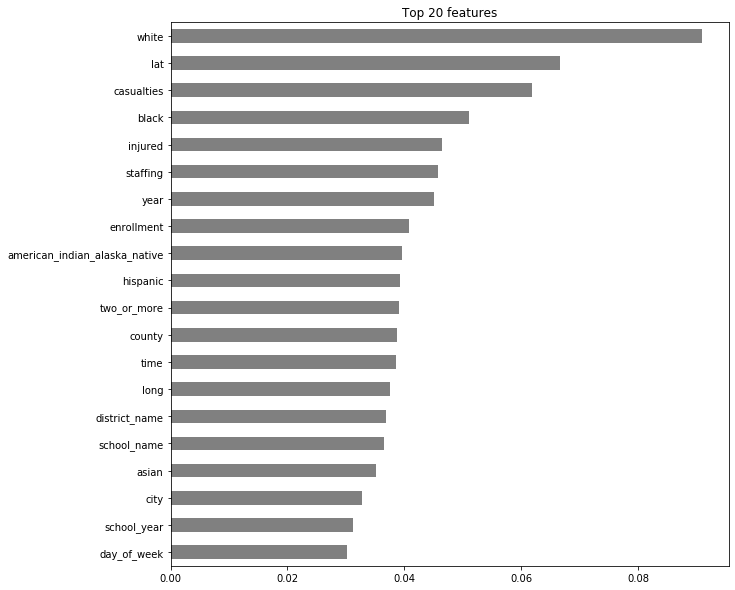

In [36]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [37]:
transformers = make_pipeline(
    ce.OrdinalEncoder())

X_train_transformed = transformers.fit_transform(X_train)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_train_transformed, y_train)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [22]:
feature_names = X_train.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

long                                0.000000
district_name                       0.000000
resource_officer                    0.000000
low_grade                           0.000000
two_or_more                         0.000000
hawaiian_native_pacific_islander    0.000000
city                                0.000000
state                               0.000000
school_type                         0.000000
enrollment                          0.000000
killed                              0.000000
american_indian_alaska_native       0.000000
high_grade                          0.000000
school_name                         0.001053
asian                               0.002105
day_of_week                         0.002105
time                                0.002105
school_year                         0.003158
injured                             0.003158
black                               0.005263
hispanic                            0.005263
staffing                            0.005263
casualties

In [24]:
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names) # must be a list

Weight,Feature
0.0526 ± 0.0305,white
0.0137 ± 0.0052,lat
0.0084 ± 0.0052,year
0.0063 ± 0.0079,county
0.0053 ± 0.0000,casualties
0.0053 ± 0.0067,staffing
0.0053 ± 0.0000,hispanic
0.0053 ± 0.0067,black
0.0032 ± 0.0052,injured
0.0032 ± 0.0052,school_year


In [25]:
X_train.shape

(190, 27)

In [0]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]
X_test = X_test[features]

In [42]:
# Dropped another 13 columns
X_train.shape, X_test.shape

((190, 14), (48, 14))

In [43]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['school_name', 'school_year', 'time',
                                      'day_of_week', 'county'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'school_name',
                                          'data_type': dtype('O'),
                                          'mapping': Fort Gibson Middle School         1
Simonsdale Elementary School      2
St. James Catholic School         3
Dorchester High School            4...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=N

In [45]:
# The score will be worse, but haven't tuned hyperparameters yet
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.5


In [72]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = XGBClassifier(
    n_estimators=1000, # <= 1000 trees, depend on early stopping
    max_depth=7,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.5, # try higher learning rate
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train),
            (X_test_encoded, y_test)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='merror', 
          early_stopping_rounds=50)

[0]	validation_0-merror:0.068421	validation_1-merror:0.5
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.036842	validation_1-merror:0.458333
[2]	validation_0-merror:0.021053	validation_1-merror:0.541667
[3]	validation_0-merror:0	validation_1-merror:0.541667
[4]	validation_0-merror:0	validation_1-merror:0.5
[5]	validation_0-merror:0	validation_1-merror:0.520833
[6]	validation_0-merror:0	validation_1-merror:0.520833
[7]	validation_0-merror:0	validation_1-merror:0.520833
[8]	validation_0-merror:0	validation_1-merror:0.5
[9]	validation_0-merror:0	validation_1-merror:0.5
[10]	validation_0-merror:0	validation_1-merror:0.520833
[11]	validation_0-merror:0	validation_1-merror:0.458333
[12]	validation_0-merror:0	validation_1-merror:0.458333
[13]	validation_0-merror:0	validation_1-merror:0.479167
[14]	validation_0-merror:0	validation_1-merror:0.479167
[15]	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

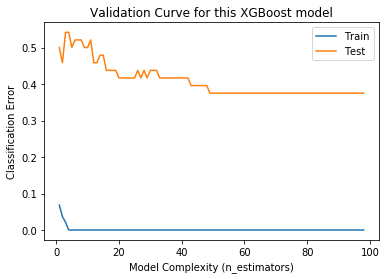

In [49]:
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Test')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
#plt.ylim((0.35, 0.6)) # Zoom in
plt.legend();

In [0]:
# Why won't this run??

# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.feature_selection import f_classif, SelectKBest
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import Ridge

# pipeline = make_pipeline(
#     ce.OrdinalEncoder(), 
#     StandardScaler(), 
#     SelectKBest(f_classif), 
#     Ridge()
# )

# param_distributions = { 
#     'selectkbest__k': range(1, len(X_train.columns)+1), 
#     'ridge__alpha': [0.1, 0.01, 1, 10], 
# }

# search = RandomizedSearchCV(
#     pipeline, 
#     param_distributions=param_distributions, 
#     n_iter=100, 
#     cv=5, 
#     scoring='accuracy', 
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-1
# )

# search.fit(X_train, y_train);

In [55]:
X_train.shape, y_train.shape

((190, 14), (190,))